In [100]:
import pandas as pd
import seaborn as sbs
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, plot_confusion_matrix

from keras.models import Model, Sequential
from keras.layers import LSTM, Dense

In [53]:
def generate_np_data(dataframe_X, dataframe_Y, look_back, predict_forward, N, categorize = False):
    X = []
    Y = []
    
    dataframe_X = np.array(dataframe_X)
    dataframe_Y = np.array(dataframe_Y)
    
    for i in range(N - look_back - predict_forward):
        x_ = dataframe_X[i:i+look_back]
        y_ = dataframe_Y[i+look_back - 1 + predict_forward]
        
        if not np.isnan(x_).any() and not np.isnan(y_).any():
            X.append(x_)
            
            if categorize:
                Y.append(1 if y_ > 0 else 0)
            else:
                Y.append(y_)
 
    
    return np.array(X), np.array(Y)

In [97]:
def get_model_lstm(n_steps, n_features):
    model = Sequential()
    
    model.add(LSTM(128, input_shape=(n_steps, n_features)))

    model.add(Dense(1, activation = 'sigmoid'))
    
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics =['acc'])
    
    return model

---

# Loading Data|

In [2]:
# https://www.kaggle.com/PROPPG-PPG/hourly-weather-surface-brazil-southeast-region
data = pd.read_csv("sudeste.csv")

In [3]:
data.describe()

,wsid,elvt,lat,lon,yr,mo,da,hr,prcp,stp,...,tmax,dmax,tmin,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
count,9.779168e+06,9.779168e+06,9.779168e+06,9.779168e+06,9.779168e+06,9.779168e+06,9.779168e+06,9.779168e+06,1.407984e+06,9.779168e+06,...,9.779142e+06,9.778858e+06,9.779134e+06,9.778361e+06,9.779168e+06,9.779156e+06,9.779124e+06,8.853607e+06,9.779168e+06,9.462694e+06
mean,3.592531e+02,5.940923e+02,-2.023082e+01,-4.464590e+01,2.011164e+03,6.521960e+00,1.575465e+01,1.150000e+01,9.366544e-01,8.804292e+02,...,2.110503e+01,1.524025e+01,1.986418e+01,1.422089e+01,6.726667e+01,6.996991e+01,6.441965e+01,1.998156e+00,1.385991e+02,4.494015e+00
std,3.901630e+01,3.980379e+02,3.172643e+00,4.882117e+00,3.207774e+00,3.425538e+00,8.802154e+00,6.922190e+00,2.923291e+00,2.482650e+02,...,7.545549e+00,5.866811e+00,7.134849e+00,5.777089e+00,2.654213e+01,2.643371e+01,2.656550e+01,1.618531e+00,1.052018e+02,2.981790e+00
min,1.780000e+02,0.000000e+00,-2.496282e+01,-5.667732e+01,2.000000e+03,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,-3.200000e+00,-1.000000e+01,-8.500000e+00,-1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.280000e+02,2.830000e+02,-2.239580e+01,-4.743410e+01,2.009000e+03,4.000000e+00,8.000000e+00,5.000000e+00,0.000000e+00,9.113000e+02,...,1.820000e+01,1.270000e+01,1.720000e+01,1.160000e+01,5.300000e+01,5.800000e+01,4.900000e+01,8.000000e-01,5.600000e+01,2.300000e+00
50%,3.580000e+02,5.730000e+02,-2.075041e+01,-4.445378e+01,2.011000e+03,7.000000e+00,1.600000e+01,1.200000e+01,0.000000e+00,9.442000e+02,...,2.190000e+01,1.660000e+01,2.080000e+01,1.560000e+01,7.400000e+01,7.800000e+01,7.000000e+01,1.700000e+00,1.140000e+02,4.200000e+00
75%,3.940000e+02,8.750000e+02,-1.891707e+01,-4.243575e+01,2.014000e+03,9.000000e+00,2.300000e+01,1.800000e+01,6.000000e-01,9.731000e+02,...,2.580000e+01,1.940000e+01,2.420000e+01,1.840000e+01,8.900000e+01,9.100000e+01,8.600000e+01,2.900000e+00,2.160000e+02,6.300000e+00
max,4.230000e+02,1.758000e+03,0.000000e+00,0.000000e+00,2.016000e+03,1.200000e+01,3.100000e+01,2.300000e+01,1.000000e+02,1.050000e+03,...,4.500000e+01,4.480000e+01,4.500000e+01,4.490000e+01,1.000000e+02,1.000000e+02,1.000000e+02,1.980000e+01,3.600000e+02,5.000000e+01


__wsid__:
- Weather station id

__wsnm__:
- Name station (usually city location or nickname)

__evlt__:
- Elevation

__elvt__:
- Elevation

__lat__:
- Latitude

__lon__:
- Longitude

__inme__:
- Station number (INMET number) for the location

__city__:
- City

__prov__:
- State (Province)

__date__:
- Date of observation
    
__yr__:
- The year (2000-2016)

__mo__:
- The month (0-12)

__da__:
- The day (0-31)

__hr__:
- The hour (0-23)

__prcp__:
- Amount of precipitation in millimetres (last hour)

__stp__:
- Air pressure for the hour in hPa to tenths (instant)

__smax__:
- Maximum air pressure for the last hour in hPa to tenths

__smin__:
- Minimum air pressure for the last hour in hPa to tenths

__gbrd__:
- Solar radiation KJ/m2

__temp__:
- Air temperature (instant) in celsius degrees

__dewp__:
- Dew point temperature (instant) in celsius degrees

__dmax__:
- Maximum dew point temperature for the last hour in celsius degrees

__dmin__:
- Minimum dew point temperature for the last hour in celsius degrees

__hmax__:
- Maximum relative humid temperature for the last hour in %

__hmin__:
- Minimum relative humid temperature for the last hour in %

__wdsp__:
- Wind speed in metres per second

__wdct__:
- Wind direction in radius degrees (0-360)

__gust__:
- Wind gust in metres per second
---

## Correlation Map

<AxesSubplot:>

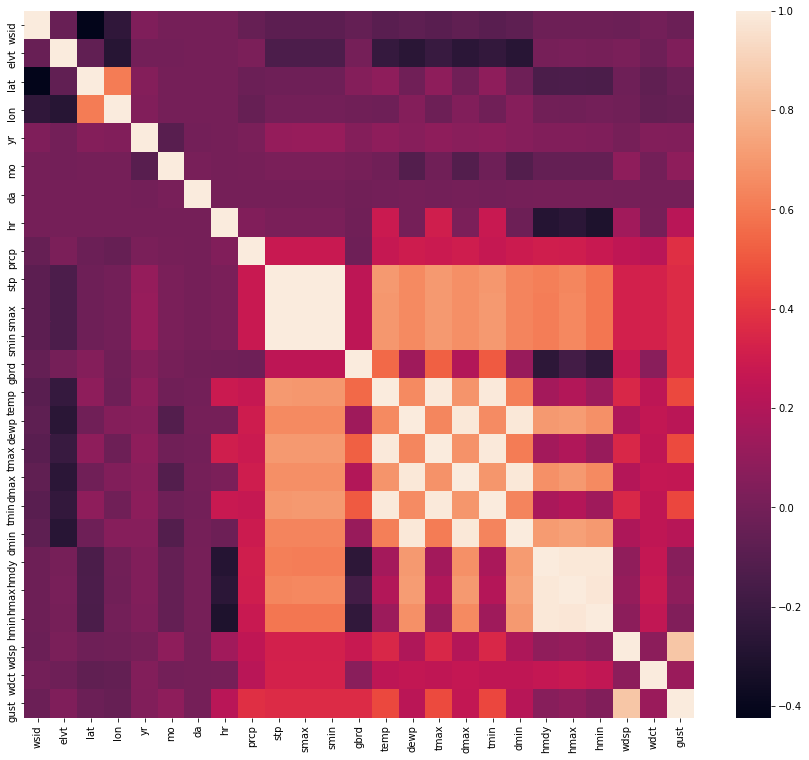

In [8]:
plt.rcParams["figure.figsize"] = [15,13]
sbs.heatmap(data.corr())

## Histogram

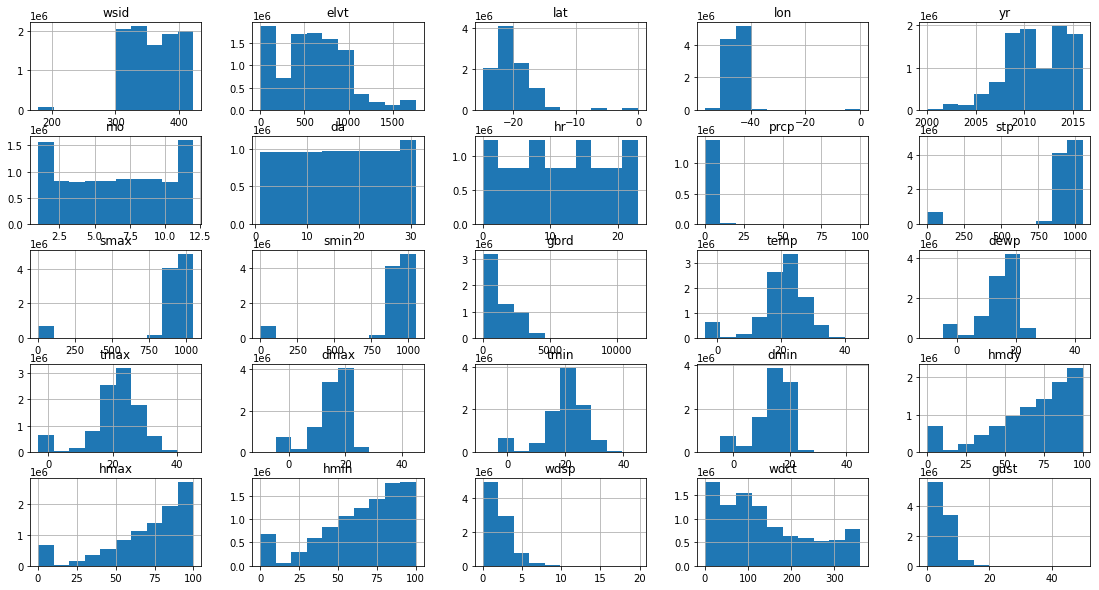

In [5]:
plt.rcParams["figure.figsize"] = [19,10]
data.hist()
plt.show()

---

# Predicting Amount of Precipitation of next 72 hours

## From stp, temp, hmin, hmax, wdsp of last 12 hours

In [139]:
X_data = data[['hr', 'stp', 'temp', 'hmin', 'hmax', 'wdsp']]
Y_data = data[['prcp']]

In [140]:
look_back = 12
predict_forward = 72
N = 500000

X, Y = generate_np_data(X_data, Y_data, look_back, predict_forward, N, True)

train_size = 0.8

X_train, X_test = X[0:int(train_size * len(X))], X[int(train_size * len(X)):]
y_train, y_test = Y[0:int(train_size * len(Y))], Y[int(train_size * len(Y)):]

## Using Random Forest, N Trees = 100

In [141]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=8)

In [142]:
s_x = X_train.shape

rf.fit(X_train.reshape(s_x[0], s_x[1] * s_x[2]), y_train)

RandomForestClassifier(n_jobs=8)

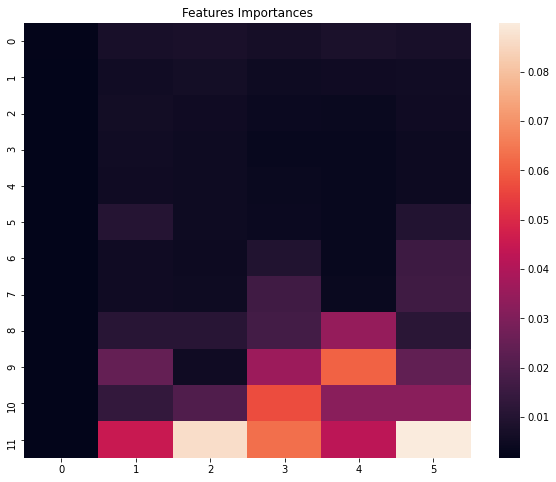

In [143]:
sbs.heatmap(rf.feature_importances_.reshape(s_x[1], s_x[2])).set_title("Features Importances")
plt.show()

### Results

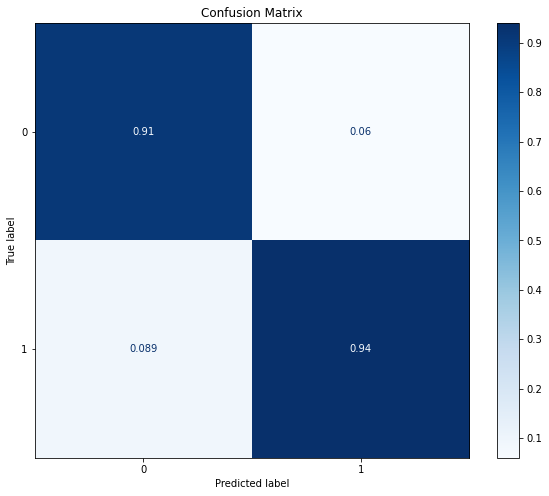

In [144]:
s_x = X_test.shape

plt.rcParams["figure.figsize"] = [10,8]
plot_confusion_matrix(rf, X_test.reshape(s_x[0], s_x[1] * s_x[2]), y_test, normalize='pred', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [145]:
y_pred = rf.predict(X_test.reshape(s_x[0], s_x[1] * s_x[2]))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.77      0.83      2314
           1       0.94      0.98      0.96      8553

    accuracy                           0.93     10867
   macro avg       0.93      0.87      0.90     10867
weighted avg       0.93      0.93      0.93     10867



---

## Using Gaussian Naive Bayes

In [146]:
nb = GaussianNB()

In [147]:
s_x = X_train.shape

nb.fit(X_train.reshape(s_x[0], s_x[1] * s_x[2]), y_train)

GaussianNB()

### Results

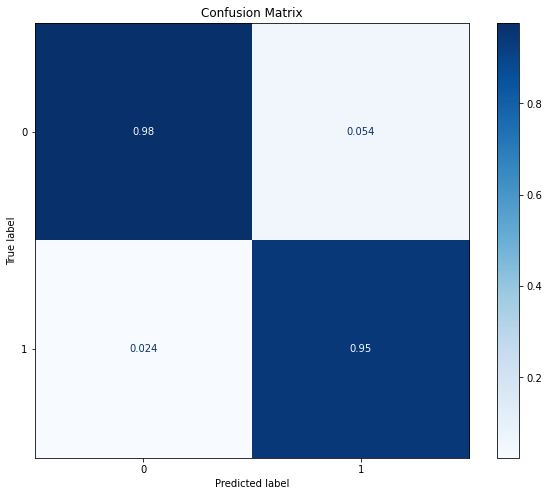

In [148]:
s_x = X_test.shape

plt.rcParams["figure.figsize"] = [10,8]
plot_confusion_matrix(nb, X_test.reshape(s_x[0], s_x[1] * s_x[2]), y_test, normalize='pred', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [149]:
y_pred = nb.predict(X_test.reshape(s_x[0], s_x[1] * s_x[2]))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.79      0.87      2314
           1       0.95      0.99      0.97      8553

    accuracy                           0.95     10867
   macro avg       0.96      0.89      0.92     10867
weighted avg       0.95      0.95      0.95     10867



---

## Using LSTM

In [150]:
model = get_model_lstm(look_back, X_train.shape[2])

In [151]:
model.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size=64, epochs=30)

Epoch 1/30
680/680 [==============================] - 4s 6ms/step - loss: 0.2700 - acc: 0.9137 - val_loss: 0.2075 - val_acc: 0.9458
Epoch 2/30
680/680 [==============================] - 4s 6ms/step - loss: 0.2668 - acc: 0.9149 - val_loss: 0.2037 - val_acc: 0.9443
Epoch 3/30
680/680 [==============================] - 4s 6ms/step - loss: 0.2656 - acc: 0.9152 - val_loss: 0.2140 - val_acc: 0.9475
Epoch 4/30
680/680 [==============================] - 4s 6ms/step - loss: 0.2653 - acc: 0.9160 - val_loss: 0.2001 - val_acc: 0.9499
Epoch 5/30
680/680 [==============================] - 4s 6ms/step - loss: 0.2642 - acc: 0.9155 - val_loss: 0.2007 - val_acc: 0.9473
Epoch 6/30
680/680 [==============================] - 4s 6ms/step - loss: 0.2630 - acc: 0.9162 - val_loss: 0.2061 - val_acc: 0.9461
Epoch 7/30
680/680 [==============================] - 4s 6ms/step - loss: 0.2627 - acc: 0.9161 - val_loss: 0.2027 - val_acc: 0.9472
Epoch 8/30
680/680 [==============================] - 4s 6ms/step - loss: 0.

In [153]:
y_pred = model.predict(X_test) > 0.5
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.79      0.87      2314
           1       0.95      0.99      0.97      8553

    accuracy                           0.95     10867
   macro avg       0.96      0.89      0.92     10867
weighted avg       0.95      0.95      0.95     10867

